In [1]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from torch import tensor
import numpy as np
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import random
import os
import matplotlib.pyplot as plt
#from numba import jit
import pickle
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader, random_split
import torch
from torchsummary import summary
import seaborn as sns

# Req for package
import sys
sys.path.append("../")
from SkinLearning.NN.Helpers import train, test, DEVICE, get_parameter_loss, set_seed
from SkinLearning.Utils.Dataset import get_dataset, get_split
from SkinLearning.Utils.Plotting import plot_parameter_bars


# Model

In [2]:
# Up samples to 256 from 128
class Single2D(nn.Module):
    def __init__(self):
        super(Single2D, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, padding=3)
        self.bn1 = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(256)
        
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(512)
        
        self.conv4 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn5 = nn.BatchNorm2d(128)
        
        
        self.fc1 = nn.Linear(7680, 512)
        self.d1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(512, 256)
        self.d2 = nn.Dropout(0.25)
        
        self.fc3 = nn.Linear(256, 64)
        self.d3 = nn.Dropout(0.25)
        
        self.fc4 = nn.Linear(64, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.unsqueeze(1)
        #x = x.reshape(batch_size, 1, 2, 128)
        print(x.shape)
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        
        x = self.fc4(x)
        return x

In [3]:
# Up samples to 128 from 32
class DualDownUp(nn.Module):
    def __init__(self):
        super(DualDownUp, self).__init__()
        self.conv1 = nn.Conv1d(2, 32, kernel_size=5, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=5)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(256)
        
        self.fc1 = nn.Linear(768, 128)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 64)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(64, 32)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(32, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        #x = self.pool5(torch.relu(self.bn5(self.conv5(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        #x = x.view(batch_size, -1)
        x = x.view(batch_size, -1)

        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        x = self.fc4(x)
        return x

In [4]:
# Up samples to 128 from 32
class DualUpDown(nn.Module):
    def __init__(self):
        super(DualUpDown, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=5)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.conv4 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(64)
        
        self.fc1 = nn.Linear(192, 64)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(64, 32)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(32, 16)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(16, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        #x = self.pool5(torch.relu(self.bn5(self.conv5(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        #x = x.view(batch_size, -1)
        x = x.view(batch_size, -1)

        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        x = self.fc4(x)
        return x

In [5]:
# Up samples to 128 from 32
class DualDownUp(nn.Module):
    def __init__(self):
        super(DualDownUp, self).__init__()
        self.conv1 = nn.Conv1d(2, 32, kernel_size=5, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=5)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(256)
        
        self.fc1 = nn.Linear(768, 128)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 64)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(64, 32)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(32, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        #x = self.pool5(torch.relu(self.bn5(self.conv5(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        #x = x.view(batch_size, -1)
        x = x.view(batch_size, -1)

        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        x = self.fc4(x)
        return x

In [6]:
# Up samples to 256 from 128
class DualUp(nn.Module):
    def __init__(self):
        super(DualUp, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.conv4 = nn.Conv1d(512, 1024, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(1024)
        
        
        self.fc1 = nn.Linear(7680, 512)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, 64)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(64, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        
        x = self.fc4(x)
        return x

In [7]:
# Down samples from 128 features
class DualDown(nn.Module):
    def __init__(self):
        super(DualDown, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding='same')
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = nn.Conv1d(64, 32, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(32)
        
        self.conv4 = nn.Conv1d(32, 16, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(16)
        
        self.fc1 = nn.Linear(112, 64)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(64, 32)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(32, 16)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(16, 6)

    def forward(self, x):
        #x = x.type(torch.FloatTensor)
        #print(type(x))# Train/test functions
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        
        
        x = self.fc4(x)
        return x

In [ ]:
summary()

# Dataset

In [8]:
set_seed()

In [9]:
dataset, scaler = get_dataset()

100%|██████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:50<00:00, 44.73it/s]


## Train/test split

In [10]:
train_loader, test_loader = get_split(dataset)

In [11]:
len(dataset[0])

2

# Training/testing

In [11]:
downUp = DualDownUp() # Extracts 32, then takes to 128

In [12]:
downUpLoss, downUp_vloss = train(train_loader, downUp, val_loader=test_loader, LR=0.0001, epochs=500)

Using: cuda


100%|████████████████████| 113/113 [00:01<00:00, 65.79batch/s, counter=0, epoch=136/500, lastLoss=0.129, valLoss=0.134]


100%|████████████████████| 113/113 [00:01<00:00, 66.35batch/s, counter=0, epoch=272/500, lastLoss=0.117, valLoss=0.145]


100%|████████████████████| 113/113 [00:01<00:00, 64.17batch/s, counter=0, epoch=408/500, lastLoss=0.114, valLoss=0.134]


100%|████████████████████| 113/113 [00:01<00:00, 65.99batch/s, counter=0, epoch=500/500, lastLoss=0.111, valLoss=0.162]


Average train loss: 0.12542212457338398
Average validation loss: 0.12634801506430937


In [63]:
up = DualUp() # Upsamples to 256 features

In [14]:
test(test_loader, downUp, scaler)

(25.949596,
 array([ 6.754989  , 47.73569   ,  0.29243132,  0.6513859 , 59.09205   ,
        41.171005  ], dtype=float32),
 0.11458810932677367)

In [64]:
upLoss, up_vloss = train(train_loader, up, val_loader=test_loader, LR=0.000005, epochs=500)

Using: cuda


100%|██████████████████████| 113/113 [00:01<00:00, 79.02batch/s, counter=0, epoch=136/500, lastLoss=0.15, valLoss=0.11]


100%|███████████████████| 113/113 [00:00<00:00, 134.69batch/s, counter=0, epoch=272/500, lastLoss=0.131, valLoss=0.108]


100%|██████████████████| 113/113 [00:00<00:00, 127.69batch/s, counter=0, epoch=408/500, lastLoss=0.119, valLoss=0.0854]


100%|██████████████████| 113/113 [00:00<00:00, 118.14batch/s, counter=0, epoch=500/500, lastLoss=0.113, valLoss=0.0806]


Average train loss: 0.14046346311686578
Average validation loss: 0.10788445234106019


In [20]:
down = DualDown() # Downsamples from 128 to 32

In [21]:
downLoss, down_vloss = train(train_loader, down, val_loader=test_loader, LR=0.0001, epochs=500)

Using: cuda


100%|████████████████████| 113/113 [00:00<00:00, 116.80batch/s, counter=0, epoch=136/500, lastLoss=0.145, valLoss=0.12]


100%|███████████████████| 113/113 [00:01<00:00, 110.08batch/s, counter=0, epoch=272/500, lastLoss=0.139, valLoss=0.118]


100%|███████████████████| 113/113 [00:00<00:00, 118.70batch/s, counter=0, epoch=408/500, lastLoss=0.137, valLoss=0.115]


100%|███████████████████| 113/113 [00:01<00:00, 100.67batch/s, counter=0, epoch=500/500, lastLoss=0.136, valLoss=0.117]


Average train loss: 0.14721006793743083
Average validation loss: 0.1272157382949673


In [22]:
upDown = DualUpDown()

In [ ]:
test(test_loader, downUp, scaler)

In [23]:
upDownLoss, upDown_vloss = train(train_loader, upDown, val_loader=test_loader, LR=0.0001, epochs=1000)

Using: cuda


100%|███████████████████| 113/113 [00:01<00:00, 101.48batch/s, counter=0, epoch=136/500, lastLoss=0.144, valLoss=0.121]


100%|███████████████████| 113/113 [00:01<00:00, 106.10batch/s, counter=0, epoch=272/500, lastLoss=0.138, valLoss=0.123]


100%|███████████████████| 113/113 [00:00<00:00, 115.07batch/s, counter=0, epoch=408/500, lastLoss=0.135, valLoss=0.117]


100%|████████████████████| 113/113 [00:00<00:00, 113.57batch/s, counter=0, epoch=500/500, lastLoss=0.135, valLoss=0.12]


Average train loss: 0.14625904033329767
Average validation loss: 0.12738304916872034


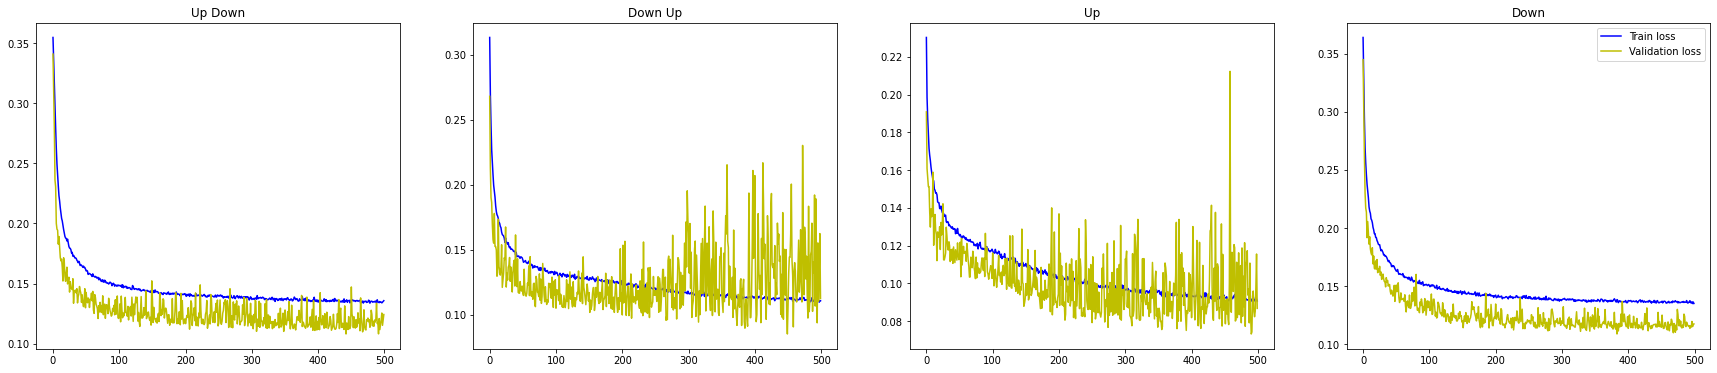

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(30, 6))
x = range(0, 500)

#ax[0][1].set_xlabel("Training Loss")
##ax[1][1].set_xlabel("Validation Loss")

ax[0].set_title("Up Down")
ax[1].set_title("Down Up")
ax[2].set_title("Up")
ax[3].set_title("Down")


for i, res in enumerate([(upDownLoss, upDown_vloss), (downUpLoss, downUp_vloss), (upLoss, up_vloss), (downLoss, down_vloss)]):
    for j in range(2):
        ax[i].plot(x, res[j], c = "b" if j == 0 else "y", label = "Train loss" if j == 0 else "Validation loss")
plt.legend()    
plt.show()

# Results

In [61]:
print(list(zip(["t1", "t2", "t3"], ["v1", "v2", "v3"])))

[('t1', 'v1'), ('t2', 'v2'), ('t3', 'v3')]


In [242]:
sns.set_theme()

"""
    Plots train and test curves of given models
"""
def printCurves(models, names, train_loss, val_loss, epochs=500):
    fig, ax = plt.subplots(
        len(models)//2, len(models)//2, figsize=(35, len(models)*6), sharex=True, sharey=True, constrained_layout=True)
    x = range(0, epochs)
    fig.supxlabel("Epoch", fontsize=45)
    fig.supylabel("MAE", fontsize=45)

    #ax[0][1].set_xlabel("Training Loss")
    ##ax[1][1].set_xlabel("Validation Loss")
    
    tv_loss = list(zip(train_loss, val_loss))
    for i in range(len(models)//2):
        for j in range(len(models)//2):
            ax[i][j].set_title(names[i+j], fontsize=40)
            ax[i][j].xaxis.set_tick_params(labelsize=35)
            ax[i][j].yaxis.set_tick_params(labelsize=35)
            for k in range(2):
                ax[i][j].plot(x, tv_loss[i+j][k], c = "b" if k == 0 else "y", label = "Train loss" if k == 0 else "Validation loss")
    
    
    """ for i in range(len(tv_loss)):
        for j in range(2):
            print(i//2)
            print(0 if i < len(models)//2 else 1, i//len(models)//2)
            ax[0 if i < len(models)//2 else 1][i//len(models)//2].plot(x, tv_loss[i][j], c = "b" if j == 0 else "y", label = "Train loss" if j == 0 else "Validation loss")"""
    
    #plt.xticks(fontsize=14, rotation=90)
    plt.legend()
    plt.show()
    fig.savefig("../Results/testArchitectures.svg", dpi="figure")

In [1]:
train_loss = [upDownLoss, downUpLoss, upLoss, downLoss]
val_loss = [upDown_vloss, downUp_vloss, up_vloss, down_vloss]
printCurves([upDown, downUp, up, down], ["Up Down", "Down Up", "Up", "Down"], train_loss, val_loss)

NameError: name 'upDownLoss' is not defined

4

In [326]:
"""
    Run evaluation and build a dataframe of parameter accuracies
    Accuracies are calculated as 100-loss as a percentage of the original value
"""
def getParameterLoss(models, names, test_loader=test_loader, mspe_based=True):
    params = []
    overall = []
    
    # Run evaluation on all models
    for model in models:
        if mspe_based:
            ps, avg, _ = test(test_loader, model)
        else:
            ps, _, avg = test(test_loader, model)
        overall.append(avg)
        params.append(ps)
    
    all_vals = np.array(params)
    df = pd.DataFrame({
        "Architecture": names,
        "YM (Skin)": all_vals[:, 0],
        "YM (Adipose)": all_vals[:, 1],
        "PR (Skin)": all_vals[:, 2],
        "PR (Adipose)": all_vals[:, 3],
        "Perm (Skin)": all_vals[:, 4],
        "Perm (Adipose)": all_vals[:, 5],
        "Overall": np.mean(overall, axis=1)
    })
    
    df = df.set_index("Architecture")
    df_p = df.style.set_caption(
        'Average percent correctness 100-MAPE' if mspe_based else "Average denormalised correctnessss 100-(abs(target-predicted)/target)*100)").set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'black'),
            ('font-size', '16px'),
            ('text-align', 'center')
        ]
    }])
    display(df_p)
    
    return df
    
"""printVals = lambda x: print(''.join(
    'YM 1: {:.2f}%, YM 2: {:.2f}%, PR 1: {:.2f}%,  PR 2: {:.2f}%, Perm 1: {:.2f}%, Perm 2: {:.2f}%'.format(*x)))    """

"printVals = lambda x: print(''.join(\n    'YM 1: {:.2f}%, YM 2: {:.2f}%, PR 1: {:.2f}%,  PR 2: {:.2f}%, Perm 1: {:.2f}%, Perm 2: {:.2f}%'.format(*x)))    "

In [325]:
DEVICE

device(type='cuda', index=0)

In [44]:
models, names = [upDown, downUp, up, down], ["Up Down", "Down Up", "Up", "Down"]
df = get_parameter_loss(models, names, test_loader, scaler)

ValueError: not enough values to unpack (expected 4, got 3)

Text(0.5, 1.08, 'Average denormalised correctnessss 100-(abs(target-predicted)/target)*100)')

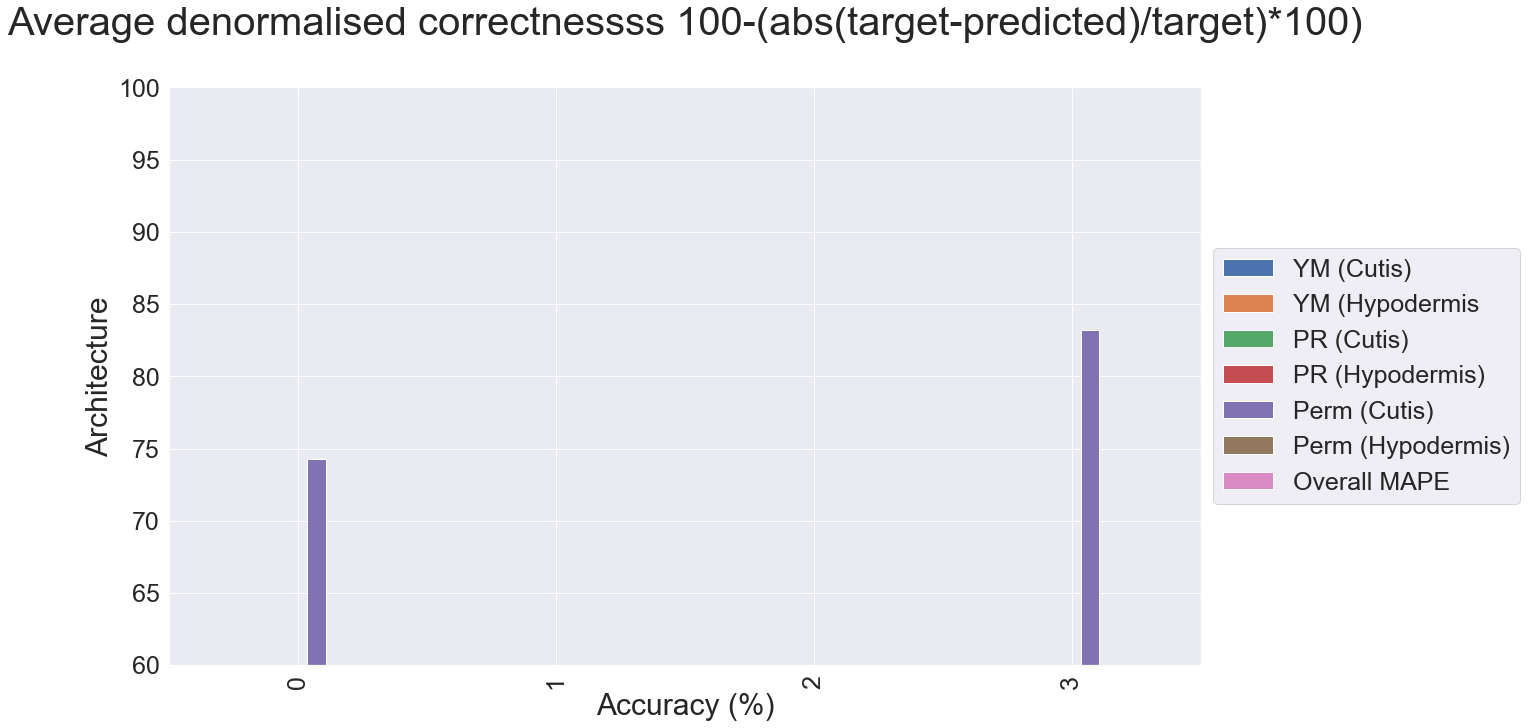

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
df.plot.bar(ax=ax)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.set_ylabel("Architecture", fontsize=30)
ax.set_xlabel("Accuracy (%)", fontsize=30)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),  prop={'size': 25})
ax.set_ylim(60, 100)
ax.set_title("Average denormalised correctnessss 100-(abs(target-predicted)/target)*100)", size=40, y=1.08)
#fig.savefig("../Results/testArchitecturesbar.svg", bbox_inches='tight')

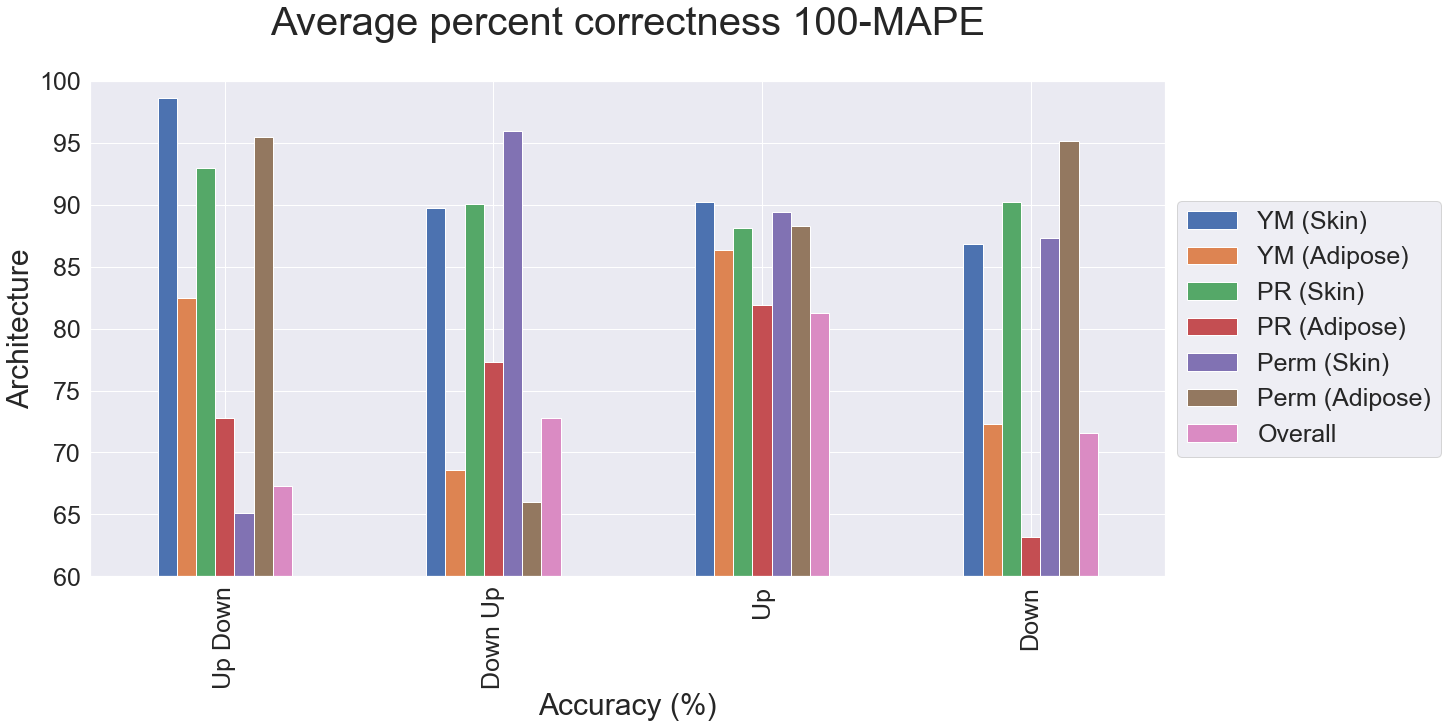

In [341]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
df.plot.bar(ax=ax)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.set_ylabel("Architecture", fontsize=30)
ax.set_xlabel("Accuracy (%)", fontsize=30)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),  prop={'size': 25})
ax.set_title("Average percent correctness 100-MAPE", size=40, y=1.08)
ax.set_ylim(60, 100)
fig.savefig("../Results/testArchitecturesbarmspe.svg", bbox_inches='tight')

In [66]:
p_losses, maes, mapes = [], [], []
for model in [upDown, downUp, up, down]:
    mape, p_loss, mae = test(test_loader, model, scaler)
    
    p_losses.append(p_loss)
    maes.append(mae)
    mapes.append(mape)

p_losses = np.array(p_losses)


#all_vals = np.array([upDown_p, downUp_p, down_p, down_p])
#all_vals = np.array([[str(val)+"%" for val in vals] for vals in all_vals])

print(mapes, maes, p_losses[:, 0])
"""df = pd.DataFrame({
    "Architecture": ["Up-then-down", "Down-then-up", "Up", "Down"],

    "MAE": maes
})"""

df = pd.DataFrame({
    "Architecture": ["Up-then-down", "Down-then-up", "Up", "Down"],
    "YM (Cutis)": p_losses[:, 0],
    "YM (Hypodermis": p_losses[:, 1],
    "PR (Cutis)": p_losses[:, 2],
    "PR (Hypodermis)": p_losses[:, 3],
    "Perm (Cutis)": p_losses[:, 4],
    "Perm (Hypodermis)": p_losses[:, 5],
    "Overall MAPE": maes
})





[32.275284, 25.605381, 13.654003, 32.183426] [0.12437148289433841, 0.11359047684176214, 0.07940243146029012, 0.11524521970543368] [6.1328425 7.2440047 5.48442   6.078677 ]


In [54]:
df

,Architecture,YM (Skin),YM (Adipose,PR (Skin),PR (Adipose),Perm (Skin),Perm (Adipose),Overall MAPE
0,Up-then-down,6.689407,62.551624,0.295499,0.777797,82.447433,59.309254,0.128364
1,Down-then-up,6.791126,45.242710,0.279054,0.635120,50.548820,40.779404,0.111444
2,Up,5.692251,33.874622,0.282635,0.382469,44.136848,35.717560,0.085443
3,Down,6.025208,54.375439,0.285794,0.676753,82.873047,49.854385,0.115700


In [50]:
sns.set_theme()

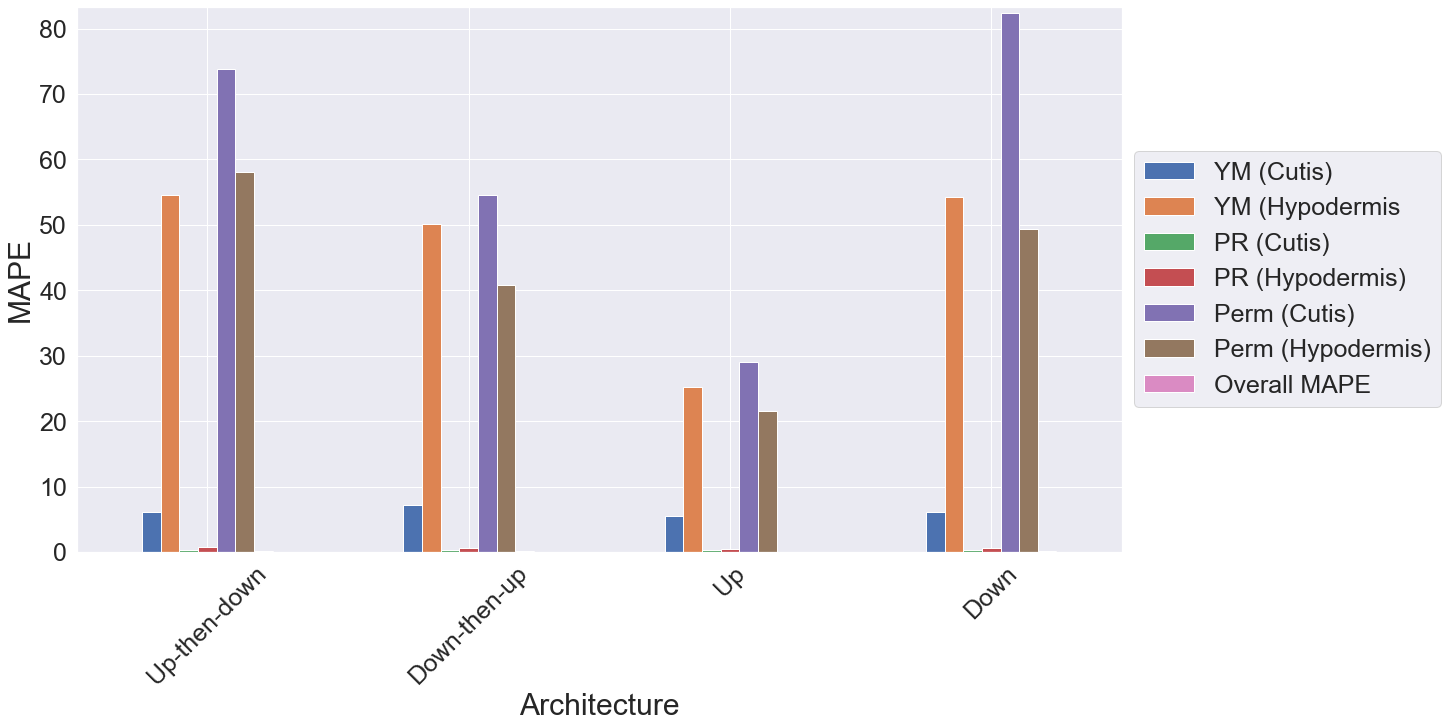

In [68]:
plot_parameter_bars(df, max_y=df.max().values[1:].max()+1)

In [67]:
def plot_parameter_bars(df, fname=None, max_y=10):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
    df.plot.bar(ax=ax, x='Architecture')
    
    ax.xaxis.set_tick_params(labelsize=25)
    ax.yaxis.set_tick_params(labelsize=25)
    ax.set_ylabel("MAPE", fontsize=30)
    ax.set_xlabel("Architecture", fontsize=30)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),  prop={'size': 25})
    #ax.set_title("Average percent correctness 100-MAPE", size=40, y=1.08)
    ax.set_ylim(0, max_y)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tick_params(axis='both', labelsize=25)

    #fig.savefig(f"../Results/figures/CNNComp.png", bbox_inches='tight')


In [51]:
upDown_p = test(test_loader, upDown)
downUp_p = test(test_loader, downUp)
up_p = test(test_loader, up)
down_p = test(test_loader, down)
all_vals = np.array([upDown_p, downUp_p, down_p, down_p])
#all_vals = np.array([[str(val)+"%" for val in vals] for vals in all_vals])



print("\nUp Down: ")
printVals(upDown_p)

print("\nDown Up: ")
printVals(downUp_p)

print("\nUp: ")
printVals(up_p)

print("\nDown: ")
printVals(down_p)

df = pd.DataFrame({
    "Architecture": ["Up Down", "Down Up", "Up", "Down"],
    "YM (Skin) %": all_vals[:, 0],
    "YM (Adipose) %": all_vals[:, 1],
    "PR (Skin) %": all_vals[:, 2],
    "PR (Adipose) %": all_vals[:, 3],
    "Perm (Skin) %": all_vals[:, 4],
    "Perm (Adipose) %": all_vals[:, 5],
})





100%|█████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 104.29 batch/s]


Up Down: 
YM 1: 93.52%, YM 2: 51.20%, PR 1: 99.72%,  PR 2: 99.34%, Perm 1: 12.20%, Perm 2: 47.81%

Down Up: 
YM 1: 93.03%, YM 2: 63.52%, PR 1: 99.72%,  PR 2: 99.27%, Perm 1: 43.16%, Perm 2: 37.81%

Up: 
YM 1: 93.80%, YM 2: 56.85%, PR 1: 99.73%,  PR 2: 99.33%, Perm 1: 66.08%, Perm 2: 71.51%

Down: 
YM 1: 93.13%, YM 2: 52.93%, PR 1: 99.72%,  PR 2: 99.35%, Perm 1: 44.28%, Perm 2: 40.15%


,YM (Skin) %,YM (Adipose) %,PR (Skin) %,PR (Adipose) %,Perm (Skin) %,Perm (Adipose) %
Architecture,,,,,,
Up Down,93.524780,51.200672,99.724449,99.342567,12.195221,47.807529
Down Up,93.033447,63.519543,99.718063,99.265930,43.159847,37.814861
Up,93.125008,52.925739,99.723457,99.350487,44.275627,40.154030
Down,93.125008,52.925739,99.723457,99.350487,44.275627,40.154030


In [57]:
import pandas as pd

data = {'YM (Skin) %': [93.524780, 93.033447, 93.125008, 93.125008],
        'YM (Adipose) %': [51.200672, 63.519543, 52.925739, 52.925739],
        'PR (Skin) %': [99.724449, 99.718063, 99.723457, 99.723457],
        'PR (Adipose) %': [99.342567, 99.265930, 99.350487, 99.350487],
        'Perm (Skin) %': [12.195221, 43.159847, 44.275627, 44.275627],
        'Perm (Adipose) %': [47.807529, 37.814861, 40.154030, 40.154030],
        'Overall': [47.81, 37.81, 71.51, 40.15],
       }

df = pd.DataFrame(data, index=['Up Down', 'Down Up', 'Up', 'Down'])

df = 100-df
df['MAE'] = [0.113585, 0.135934, 0.105497, 0.118715]
print(df)

         YM (Skin) %  YM (Adipose) %  PR (Skin) %  PR (Adipose) %  \
Up Down     6.475220       48.799328     0.275551        0.657433   
Down Up     6.966553       36.480457     0.281937        0.734070   
Up          6.874992       47.074261     0.276543        0.649513   
Down        6.874992       47.074261     0.276543        0.649513   

         Perm (Skin) %  Perm (Adipose) %  Overall       MAE  
Up Down      87.804779         52.192471    52.19  0.113585  
Down Up      56.840153         62.185139    62.19  0.135934  
Up           55.724373         59.845970    28.49  0.105497  
Down         55.724373         59.845970    59.85  0.118715  


In [247]:
np.min([[0, 1, 2, 3], [1, 2, 3, 4], [4,5, 5, 5]], axis=1)

array([0, 1, 4])

,Min. train loss,Final train loss,Min. val loss,Final val loss
Model,,,,
Up Down,0.137940,0.139313,0.110945,0.113585
Down Up,0.115668,0.116483,0.093530,0.135934
Up,0.095953,0.096501,0.073617,0.105497
Down,0.136257,0.138345,0.109146,0.118715


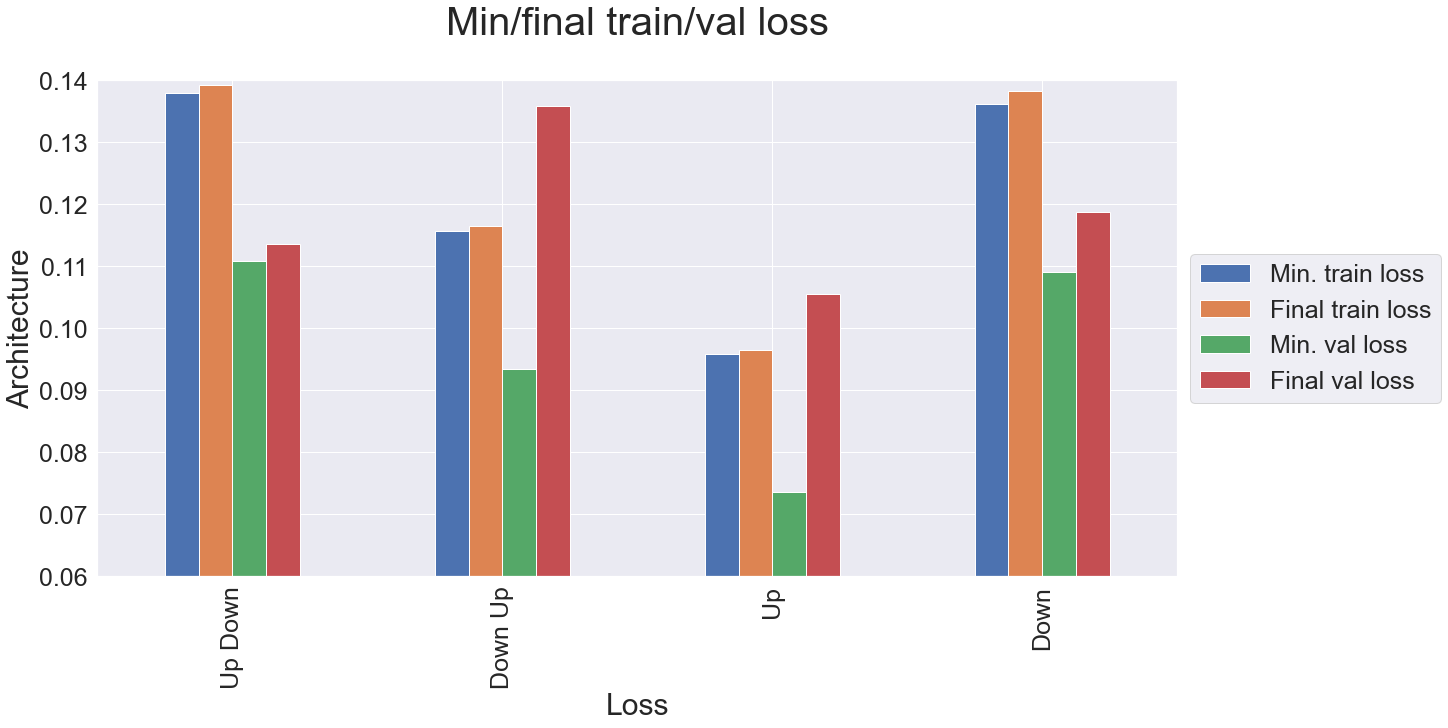

In [353]:
min_final = pd.DataFrame({
    "Model": names,
    "Min. train loss": np.min(train_loss, axis=1),
    "Final train loss": np.array(train_loss)[:, -1],
    "Min. val loss": np.min(val_loss, axis=1),
    "Final val loss": np.array(val_loss)[:, -1]
})

min_final = min_final.set_index("Model")
display(min_final)

fig, ax = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
min_final.plot.bar(ax=ax)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.set_ylabel("Architecture", fontsize=30)
ax.set_xlabel("Loss", fontsize=30)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),  prop={'size': 25})
ax.set_title("Min/final train/val loss", size=40, y=1.08)
ax.set_ylim(0.06, 0.14)
#fig.savefig("../Results/minfinalbar.svg", bbox_inches='tight')

In [116]:
wiith open("tvloss.pkl") as f:
    pickle.dumps

[5.364418029785156e-07,
 0.0757797509431839,
 0.060605406761169434,
 0.21840360760688782,
 0.15401411056518555,
 0.37659168243408203]

In [8]:
from torch.utils.tensorboard import SummaryWriter
x = torch.randn(32, 2, 128)
writer = SummaryWriter("torchlogs/")
writer.add_graph(DualUpDown(), x)
writer.close()